In [181]:
import matplotlib.pyplot as plt
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import pyspark.sql.functions as F

from pyspark.ml.feature import StandardScaler,VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from datetime import date, datetime, timedelta
import time

from pyspark.sql.functions import col, dayofweek, dayofmonth, month, to_date, year
from pyspark.sql.types import *



In [182]:
spark = SparkSession.builder.appName("Comfortable_Zone").getOrCreate()

In [183]:

nba_df = spark.read.csv("C:/Users/mayur/OneDrive/Desktop/CoursesSem2/ECC/A02/shot_logs.csv",header=True,inferSchema=True)

In [184]:
nba_df.printSchema()

root
 |-- GAME_ID: integer (nullable = true)
 |-- MATCHUP: string (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- W: string (nullable = true)
 |-- FINAL_MARGIN: integer (nullable = true)
 |-- SHOT_NUMBER: integer (nullable = true)
 |-- PERIOD: integer (nullable = true)
 |-- GAME_CLOCK: timestamp (nullable = true)
 |-- SHOT_CLOCK: double (nullable = true)
 |-- DRIBBLES: integer (nullable = true)
 |-- TOUCH_TIME: double (nullable = true)
 |-- SHOT_DIST: double (nullable = true)
 |-- PTS_TYPE: integer (nullable = true)
 |-- SHOT_RESULT: string (nullable = true)
 |-- CLOSEST_DEFENDER: string (nullable = true)
 |-- CLOSEST_DEFENDER_PLAYER_ID: integer (nullable = true)
 |-- CLOSE_DEF_DIST: double (nullable = true)
 |-- FGM: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- player_name: string (nullable = true)
 |-- player_id: integer (nullable = true)



In [185]:
nba_df.show(20)

+--------+--------------------+--------+---+------------+-----------+------+-------------------+----------+--------+----------+---------+--------+-----------+-----------------+--------------------------+--------------+---+---+-------------+---------+
| GAME_ID|             MATCHUP|LOCATION|  W|FINAL_MARGIN|SHOT_NUMBER|PERIOD|         GAME_CLOCK|SHOT_CLOCK|DRIBBLES|TOUCH_TIME|SHOT_DIST|PTS_TYPE|SHOT_RESULT| CLOSEST_DEFENDER|CLOSEST_DEFENDER_PLAYER_ID|CLOSE_DEF_DIST|FGM|PTS|  player_name|player_id|
+--------+--------------------+--------+---+------------+-----------+------+-------------------+----------+--------+----------+---------+--------+-----------+-----------------+--------------------------+--------------+---+---+-------------+---------+
|21400899|MAR 04, 2015 - CH...|       A|  W|          24|          1|     1|2023-04-21 01:09:00|      10.8|       2|       1.9|      7.7|       2|       made|   Anderson, Alan|                    101187|           1.3|  1|  2|brian roberts|   2031

In [186]:

new_df = (nba_df.dropna().toPandas())

C:\Users\mayur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyspark\sql\pandas\conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [187]:
df = nba_df.select('SHOT_DIST', 'CLOSE_DEF_DIST', 'SHOT_CLOCK').dropna()


In [188]:
df.printSchema()

root
 |-- SHOT_DIST: double (nullable = true)
 |-- CLOSE_DEF_DIST: double (nullable = true)
 |-- SHOT_CLOCK: double (nullable = true)



In [189]:
df.show()

+---------+--------------+----------+
|SHOT_DIST|CLOSE_DEF_DIST|SHOT_CLOCK|
+---------+--------------+----------+
|      7.7|           1.3|      10.8|
|     28.2|           6.1|       3.4|
|     17.2|           3.4|      10.3|
|      3.7|           1.1|      10.9|
|     18.4|           2.6|       9.1|
|     20.7|           6.1|      14.5|
|      3.5|           2.1|       3.4|
|     24.6|           7.3|      12.4|
|     22.4|          19.8|      17.4|
|     24.5|           4.7|      16.0|
|     14.6|           1.8|      12.1|
|      5.9|           5.4|       4.3|
|     26.4|           4.4|       4.4|
|     22.8|           5.3|       6.8|
|     24.7|           5.6|       6.4|
|     25.0|           5.4|      17.6|
|     25.6|           5.1|       8.7|
|     24.2|          11.1|      20.8|
|     25.4|           3.5|      17.5|
|     19.1|           4.0|      19.5|
+---------+--------------+----------+
only showing top 20 rows



In [190]:
assembler = VectorAssembler()
assembler.setInputCols(df.columns)
assembler.setOutputCol('features')
assembler_data = assembler.transform(df)


In [191]:
assembler_data.show(5)

+---------+--------------+----------+---------------+
|SHOT_DIST|CLOSE_DEF_DIST|SHOT_CLOCK|       features|
+---------+--------------+----------+---------------+
|      7.7|           1.3|      10.8| [7.7,1.3,10.8]|
|     28.2|           6.1|       3.4| [28.2,6.1,3.4]|
|     17.2|           3.4|      10.3|[17.2,3.4,10.3]|
|      3.7|           1.1|      10.9| [3.7,1.1,10.9]|
|     18.4|           2.6|       9.1| [18.4,2.6,9.1]|
+---------+--------------+----------+---------------+
only showing top 5 rows



In [192]:
def calculate_silhouette_score(data, num_clusters):
    # Train a KMeans model
    kmeans = KMeans(k=num_clusters, featuresCol='features')
    model = kmeans.fit(data)

    # Make predictions and evaluate the model
    predictions = model.transform(data)
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    return silhouette_score





In [193]:
# Calculate silhouette scores for different number of clusters
silhouette_scores = []
for k in range(2, 11):
    score = calculate_silhouette_score(assembler_data, k)
    print(score, k)
    silhouette_scores.append(score)

0.7005693569346803 2
0.6274971328256687 3
0.5550339306822153 4
0.496023939066375 5
0.5059735416306909 6
0.48779556198511104 7
0.47646810182324506 8
0.4755061270394926 9
0.48579152147457955 10


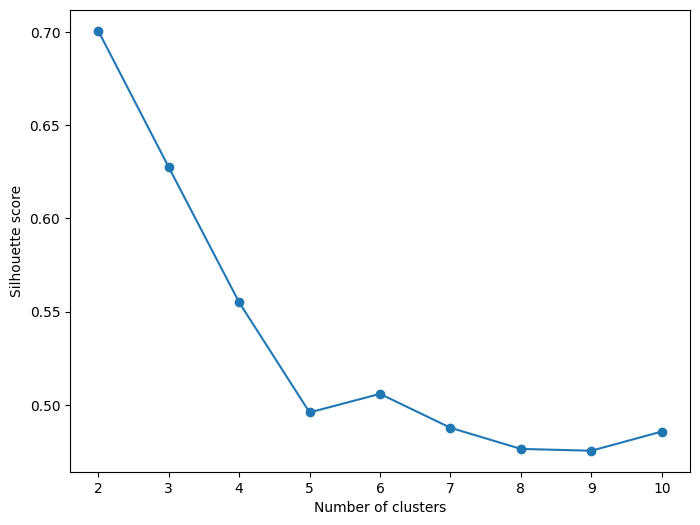

In [194]:
# Plot the silhouette scores
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(2, 11), silhouette_scores, marker='o')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_xticks(np.arange(2, 11))
plt.show()


In [195]:
# Number of clusters is 3
km = KMeans(featuresCol='features', k=5)
model = km.fit(assembler_data)
pred = model.transform(assembler_data)
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(pred)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.496023939066375


In [196]:
pred.show()

+---------+--------------+----------+----------------+----------+
|SHOT_DIST|CLOSE_DEF_DIST|SHOT_CLOCK|        features|prediction|
+---------+--------------+----------+----------------+----------+
|      7.7|           1.3|      10.8|  [7.7,1.3,10.8]|         4|
|     28.2|           6.1|       3.4|  [28.2,6.1,3.4]|         0|
|     17.2|           3.4|      10.3| [17.2,3.4,10.3]|         0|
|      3.7|           1.1|      10.9|  [3.7,1.1,10.9]|         4|
|     18.4|           2.6|       9.1|  [18.4,2.6,9.1]|         0|
|     20.7|           6.1|      14.5| [20.7,6.1,14.5]|         3|
|      3.5|           2.1|       3.4|   [3.5,2.1,3.4]|         2|
|     24.6|           7.3|      12.4| [24.6,7.3,12.4]|         3|
|     22.4|          19.8|      17.4|[22.4,19.8,17.4]|         3|
|     24.5|           4.7|      16.0| [24.5,4.7,16.0]|         3|
|     14.6|           1.8|      12.1| [14.6,1.8,12.1]|         4|
|      5.9|           5.4|       4.3|   [5.9,5.4,4.3]|         2|
|     26.4

In [197]:
centers = model.clusterCenters()


In [198]:
# Collect the predictions
predictions_collected = pred.collect()

# Select columns of interest and convert to Pandas dataframe
pred_df = pred.select(['prediction','SHOT_DIST','CLOSE_DEF_DIST','SHOT_CLOCK']).toPandas()

# Create a new Pandas dataframe with selected columns
pred_data = pred_df[['prediction','SHOT_DIST','CLOSE_DEF_DIST','SHOT_CLOCK']]

In [199]:
all_data = pd.concat([new_df, pred_data], axis=1, join='inner')
all_data.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,prediction,SHOT_DIST,CLOSE_DEF_DIST,SHOT_CLOCK
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,2023-04-21 01:09:00,10.8,2,...,101187,1.3,1,2,brian roberts,203148,4,7.7,1.3,10.8
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,2023-04-21 00:14:00,3.4,0,...,202711,6.1,0,0,brian roberts,203148,0,28.2,6.1,3.4
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,2023-04-21 11:47:00,10.3,2,...,203900,3.4,0,0,brian roberts,203148,0,17.2,3.4,10.3
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,2023-04-21 10:34:00,10.9,2,...,201152,1.1,0,0,brian roberts,203148,4,3.7,1.1,10.9
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,6,2,2023-04-21 08:15:00,9.1,2,...,101114,2.6,0,0,brian roberts,203148,0,18.4,2.6,9.1


In [200]:

all_data = new_df.merge(pred_data, on=['SHOT_DIST','CLOSE_DEF_DIST','SHOT_CLOCK'])
all_data.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,prediction
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,2023-04-21 01:09:00,10.8,2,...,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,4
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,2023-04-21 00:14:00,3.4,0,...,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,0
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,2023-04-21 11:47:00,10.3,2,...,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,0
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,2023-04-21 10:34:00,10.9,2,...,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,4
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,6,2,2023-04-21 08:15:00,9.1,2,...,2,missed,"Williams, Deron",101114,2.6,0,0,brian roberts,203148,0


In [201]:
new_df=spark.createDataFrame(all_data)
players_list = ['james harden','chris paul','stephen curry','lebron james']
new_df.head(10)

[Row(GAME_ID=21400899, MATCHUP='MAR 04, 2015 - CHA @ BKN', LOCATION='A', W='W', FINAL_MARGIN=24, SHOT_NUMBER=1, PERIOD=1, GAME_CLOCK=datetime.datetime(2023, 4, 21, 1, 9), SHOT_CLOCK=10.8, DRIBBLES=2, TOUCH_TIME=1.9, SHOT_DIST=7.7, PTS_TYPE=2, SHOT_RESULT='made', CLOSEST_DEFENDER='Anderson, Alan', CLOSEST_DEFENDER_PLAYER_ID=101187, CLOSE_DEF_DIST=1.3, FGM=1, PTS=2, player_name='brian roberts', player_id=203148, prediction=4),
 Row(GAME_ID=21400899, MATCHUP='MAR 04, 2015 - CHA @ BKN', LOCATION='A', W='W', FINAL_MARGIN=24, SHOT_NUMBER=2, PERIOD=1, GAME_CLOCK=datetime.datetime(2023, 4, 21, 0, 14), SHOT_CLOCK=3.4, DRIBBLES=0, TOUCH_TIME=0.8, SHOT_DIST=28.2, PTS_TYPE=3, SHOT_RESULT='missed', CLOSEST_DEFENDER='Bogdanovic, Bojan', CLOSEST_DEFENDER_PLAYER_ID=202711, CLOSE_DEF_DIST=6.1, FGM=0, PTS=0, player_name='brian roberts', player_id=203148, prediction=0),
 Row(GAME_ID=21400899, MATCHUP='MAR 04, 2015 - CHA @ BKN', LOCATION='A', W='W', FINAL_MARGIN=24, SHOT_NUMBER=4, PERIOD=2, GAME_CLOCK=dat

In [202]:
# Create an empty RDD
empty_rdd = spark.sparkContext.emptyRDD()

# Define the schema for the DataFrame
player_schema = StructType([
    StructField('name', StringType(), False),
    StructField('group', StringType(), False),
    StructField('hits', IntegerType(), False),
    StructField('total', IntegerType(), False)
])

# Create a DataFrame with the empty RDD and the defined schema
player_df = spark.createDataFrame(empty_rdd, schema=player_schema)

In [203]:
filtered_data = new_df.filter(new_df.player_name.isin(players_list))
data_rdd = spark.createDataFrame(data=empty_rdd,schema=player_schema)
filtered_data.createOrReplaceTempView("NBAData")

In [204]:
from pyspark.sql.functions import count, when

df = filtered_data.filter(filtered_data.SHOT_RESULT == 'made') \
            .groupBy('player_name', 'prediction') \
            .agg(count('SHOT_RESULT').alias('hits')) \
            .select('player_name', 'prediction', 'hits')
df.show()

+-------------+----------+----+
|  player_name|prediction|hits|
+-------------+----------+----+
| lebron james|         4|  94|
|stephen curry|         3| 205|
| james harden|         1| 124|
| james harden|         0| 129|
|stephen curry|         1|  84|
| lebron james|         2|  82|
|   chris paul|         3| 173|
|stephen curry|         2|  33|
|stephen curry|         0|  65|
|stephen curry|         4|  98|
| james harden|         3|  95|
| lebron james|         0| 110|
|   chris paul|         4|  76|
| james harden|         2|  40|
| james harden|         4|  99|
|   chris paul|         0| 117|
| lebron james|         1| 136|
| lebron james|         3|  72|
|   chris paul|         2|  37|
|   chris paul|         1|  28|
+-------------+----------+----+



In [206]:
result_df = filtered_data \
  .groupBy("player_name", "prediction") \
  .agg(count("*").alias("total_shots"), \
       filtered_data["player_name"].alias("player"), \
       filtered_data["prediction"].alias("cluster_group")) \
  .select("player", "cluster_group", "total_shots")

result_df.show()

+-------------+-------------+-----------+
|       player|cluster_group|total_shots|
+-------------+-------------+-----------+
| james harden|            3|        299|
| lebron james|            4|        186|
|stephen curry|            3|        478|
| lebron james|            1|        189|
|   chris paul|            3|        352|
| james harden|            1|        217|
|stephen curry|            0|        162|
| lebron james|            0|        301|
| james harden|            4|        186|
|   chris paul|            0|        267|
| lebron james|            3|        180|
| james harden|            0|        297|
|   chris paul|            2|         70|
|stephen curry|            1|        126|
| lebron james|            2|        147|
|stephen curry|            2|         57|
|stephen curry|            4|        165|
|   chris paul|            1|         45|
|   chris paul|            4|        157|
| james harden|            2|         88|
+-------------+-------------+-----

In [207]:
query1 = spark.sql("SELECT player_name,prediction as cluster,COUNT(SHOT_RESULT) as hits FROM NBAData WHERE SHOT_RESULT='made' GROUP BY player_name,prediction")

query2 = spark.sql("SELECT player_name as player,prediction as cluster_group, COUNT(*) as total_shots FROM NBAData GROUP BY player_name,prediction")


In [208]:
join_data = query1.join(query2,(query1.player_name==query2.player) & (query1.cluster==query2.cluster_group))
join_data

DataFrame[player_name: string, cluster: bigint, hits: bigint, player: string, cluster_group: bigint, total_shots: bigint]

In [209]:
join_data = join_data.withColumn("Hit_rate",(F.col("hits")/F.col("total_shots")))

In [210]:
join_data.show()

+-------------+-------+----+-------------+-------------+-----------+-------------------+
|  player_name|cluster|hits|       player|cluster_group|total_shots|           Hit_rate|
+-------------+-------+----+-------------+-------------+-----------+-------------------+
| james harden|      3|  95| james harden|            3|        299| 0.3177257525083612|
| lebron james|      4|  94| lebron james|            4|        186| 0.5053763440860215|
|stephen curry|      3| 205|stephen curry|            3|        478|0.42887029288702927|
| lebron james|      1| 136| lebron james|            1|        189| 0.7195767195767195|
|   chris paul|      3| 173|   chris paul|            3|        352| 0.4914772727272727|
| james harden|      1| 124| james harden|            1|        217| 0.5714285714285714|
|stephen curry|      0|  65|stephen curry|            0|        162| 0.4012345679012346|
| lebron james|      0| 110| lebron james|            0|        301| 0.3654485049833887|
| james harden|      

In [211]:
join_data.createOrReplaceTempView("HitRate")

In [212]:
predicted = spark.sql("SELECT player_name,cluster as comfort_zone,Hit_rate FROM HitRate WHERE Hit_rate in (SELECT max(Hit_rate) FROM HitRate GROUP BY player_name)")
predicted.show()

+-------------+------------+------------------+
|  player_name|comfort_zone|          Hit_rate|
+-------------+------------+------------------+
|   chris paul|           1|0.6222222222222222|
| lebron james|           1|0.7195767195767195|
|stephen curry|           1|0.6666666666666666|
| james harden|           1|0.5714285714285714|
+-------------+------------+------------------+



In [ ]:
Q: For each player, we define the comfortable zone of shooting is a matrix of,{SHOT DIST, CLOSE DEF DIST, SHOT CLOCK}. Please develop a Spark-based algorithm to classify each player’s records into 4 comfort-
able zones. Considering the hit rate, which zone is the best for James Harden, Chris Paul,Stephen Curry, and Lebron James. 

Ans:  
chris paul         Comfort zone 1
lebron james       Comfort zone 1
stephen curry      Comfort zone 1
james harden        Comfort zone 1